Импорт библиотек и обработка данных

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer

# Загрузка данных
train_data = pd.read_csv('/train.csv')

# Определение числовых и категориальных столбцов
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_data.columns[train_data.dtypes == 'object']

# Заполнение пропусков в категориальных признаках модой
for col in cat_cols:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)

# Заполнение пропусков в числовых признаках с помощью KNNImputer
knn_imputer = KNNImputer(n_neighbors=10)
train_data[num_cols] = knn_imputer.fit_transform(train_data[num_cols])

# Проверка на наличие пропусков
print(train_data.isnull().sum())

<ipython-input-4-7a79e026cb6b>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mode()[0], inplace=True)


ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
Interest

Очистка данных и анализ числовых признаков

In [5]:
# Удаление дубликатов
train_data.drop_duplicates(inplace=True)

# Фильтрация данных по RiskScore
train_data = train_data[(train_data['RiskScore'] > 0) & (train_data['RiskScore'] < 100)]

# Анализ числовых признаков
for col in num_cols:
    print(f"\nДля признака {col}:")
    print(f"Максимум: {train_data[col].max()}")
    print(f"Минимум: {train_data[col].min()}")
    print(f"Среднее: {train_data[col].mean()}")
    print(f"Стандартное отклонение: {train_data[col].std()}")


Для признака Age:
Максимум: 80.0
Минимум: 18.0
Среднее: 39.85349407437679
Стандартное отклонение: 11.58562117514476

Для признака AnnualIncome:
Максимум: 748508.0
Минимум: 15000.0
Среднее: 131612.62065794852
Стандартное отклонение: 115782.16876354354

Для признака CreditScore:
Максимум: 850.0
Минимум: 300.0
Среднее: 678.1589497343685
Стандартное отклонение: 173.78598057568044

Для признака LoanAmount:
Максимум: 418997.0
Минимум: 1063.0
Среднее: 29661.681181038002
Стандартное отклонение: 26806.557642037886

Для признака LoanDuration:
Максимум: 120.0
Минимум: 12.0
Среднее: 53.36616264814058
Стандартное отклонение: 24.46380058137219

Для признака NumberOfDependents:
Максимум: 6.0
Минимум: 0.0
Среднее: 1.5655905190028607
Стандартное отклонение: 1.4190781019110588

Для признака MonthlyDebtPayments:
Максимум: 10879.0
Минимум: 13.0
Среднее: 547.1601144258276
Стандартное отклонение: 492.97920682102796

Для признака CreditCardUtilizationRate:
Максимум: 0.914634661349494
Минимум: 0.003673557706

Корреляционный анализ

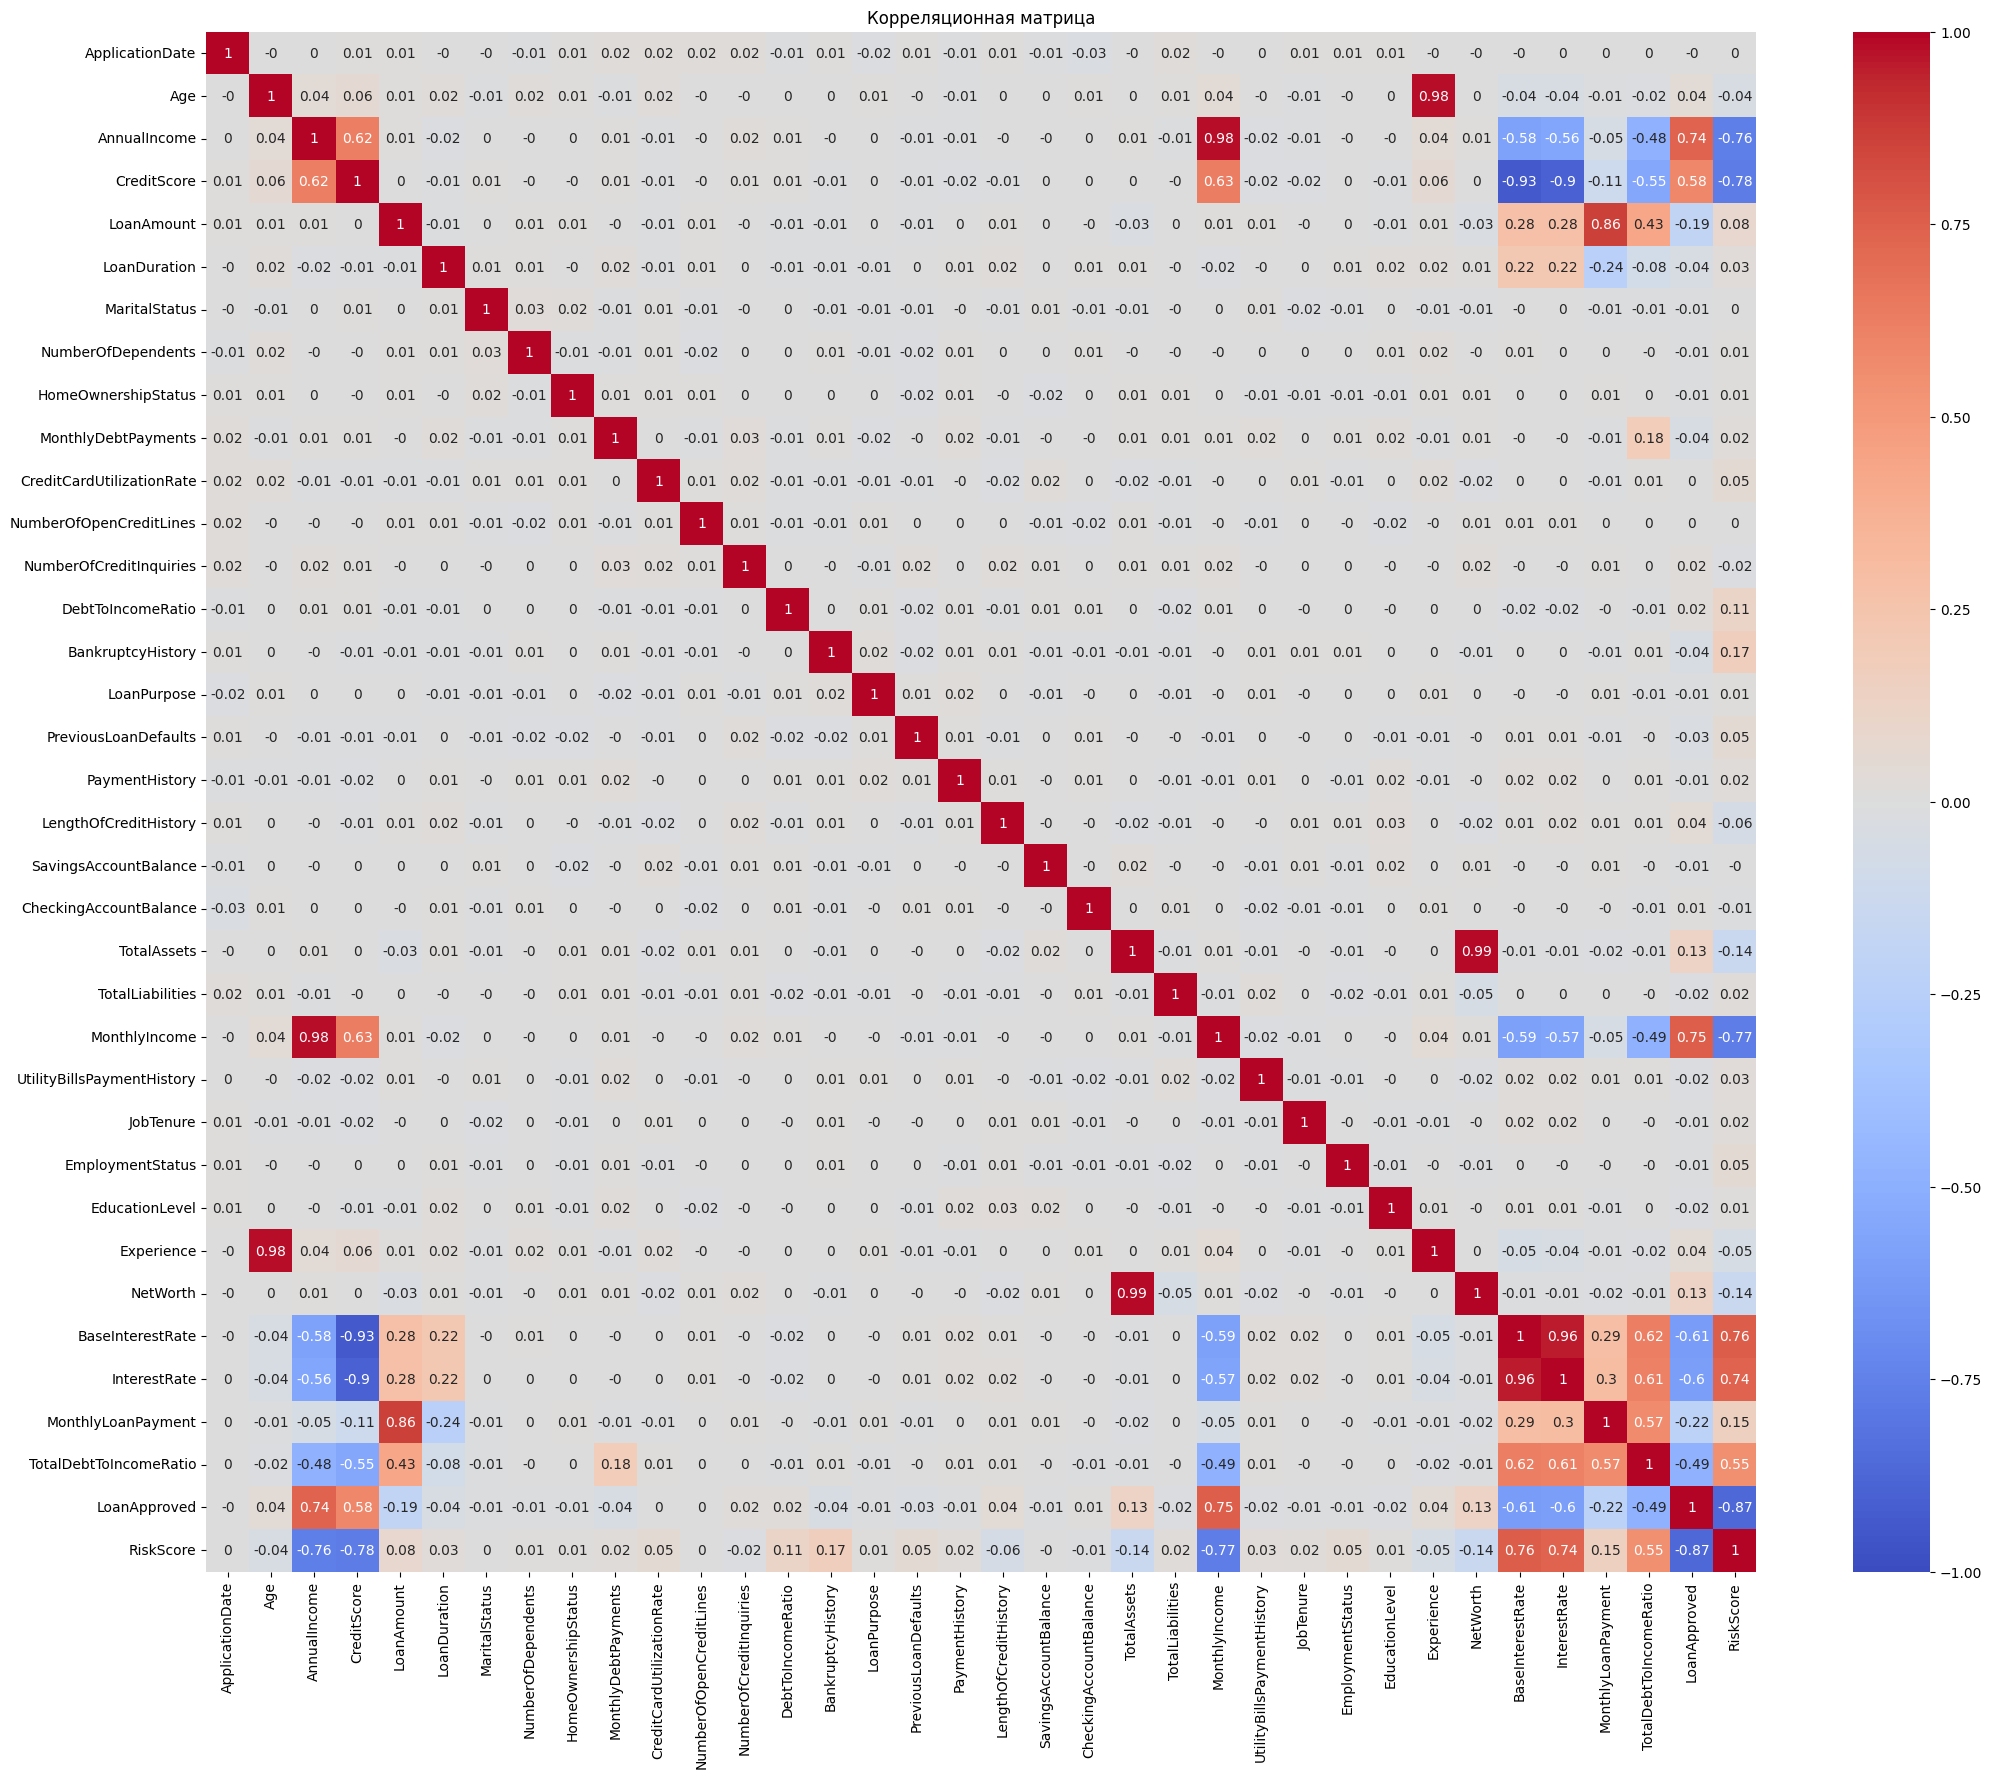

In [6]:
# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
for col in cat_cols:
    train_data[col] = label_encoder.fit_transform(train_data[col])

# Построение корреляционной матрицы
corr_matrix = train_data.corr()

plt.figure(figsize=(25, 20))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица')
plt.show()

# Корреляция целевого признака
target_col = 'RiskScore'  # Укажите здесь ваш целевой признак
target_corr = corr_matrix[target_col].sort_values(ascending=False)

print("Корреляция целевого признака:")
print(target_corr)

Выбор признаков

In [7]:
# Выбор признаков с корреляцией по модулю > 0.01
selected_features = target_corr[abs(target_corr) > 0.01].index.tolist()
selected_features.remove(target_col)

# Поиск мультикоррелирующих признаков
multi_corr = corr_matrix.unstack().loc[lambda x: (abs(x) >= 0.8) & (x != 1.0)]

# Удаление одного из признаков в каждой мультикоррелирующей паре
to_remove = set()
for (feat1, feat2), corr in multi_corr.items():
    if feat1 in selected_features and feat2 in selected_features:
        to_remove.add(feat2)

to_remove.add('RiskScore')

# Окончательный список признаков
selected_features = [feat for feat in selected_features if feat not in to_remove]
print("Окончательный список признаков:")
print(selected_features)

Окончательный список признаков:
['TotalDebtToIncomeRatio', 'BankruptcyHistory', 'DebtToIncomeRatio', 'PreviousLoanDefaults', 'CreditCardUtilizationRate', 'EmploymentStatus', 'LoanDuration', 'UtilityBillsPaymentHistory', 'TotalLiabilities', 'MonthlyDebtPayments', 'PaymentHistory', 'JobTenure', 'HomeOwnershipStatus', 'NumberOfCreditInquiries', 'LengthOfCreditHistory', 'LoanApproved']


Реализация собственного классификатора

In [8]:
import numpy as np

class CustomClassifier:
    def __init__(self, model_type='linear', learning_rate=0.01, max_iter=1000):
        self.model_type = model_type
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.max_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._activation(linear_model)

            gradient_weights = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            gradient_bias = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * gradient_weights
            self.bias -= self.learning_rate * gradient_bias

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._activation(linear_model)

    def _activation(self, x):
        if self.model_type == 'linear':
            return np.where(x >= 0, 1, 0)
        elif self.model_type == 'logistic':
            return np.where(self._sigmoid(x) > 0.5, 1, 0)
        else:
            raise ValueError("Неизвестный тип модели.")

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

Установка библиотеки CatBoost

In [9]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


Подготовка данных и обучение моделей

In [19]:
import numpy as np
import warnings

# Отключение предупреждений
warnings.filterwarnings("ignore", category=RuntimeWarning)

class CustomClassifier:
    def __init__(self, model_type='linear', learning_rate=0.01, max_iter=1000):
        self.model_type = model_type
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.max_iter):
            linear_model = np.dot(X, self.weights) + self.bias

            if self.model_type == 'linear':
                y_pred = self._step_function(linear_model)  # Линейный классификатор
            elif self.model_type == 'logistic':
                y_pred = self._sigmoid(linear_model)  # Логистическая регрессия
            else:
                raise ValueError("Неизвестный тип модели. Используйте 'linear' или 'logistic'.")

            gradient_weights = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            gradient_bias = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * gradient_weights
            self.bias -= self.learning_rate * gradient_bias

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias

        if self.model_type == 'linear':
            return self._step_function(linear_model)  # Линейный классификатор
        elif self.model_type == 'logistic':
            probabilities = self._sigmoid(linear_model)
            return np.where(probabilities > 0.5, 1, 0)  # Логистическая регрессия

    def _step_function(self, x):
        # Функция Хевисайда (ступенчатая функция)
        return np.where(x >= 0, 1, 0)

    def _sigmoid(self, x):
        # Ограничиваем значения x, чтобы избежать переполнения
        x = np.clip(x, -709, 709)
        return 1 / (1 + np.exp(-x))

# Пример использования
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Загрузка тестовых данных
test = pd.read_csv('/test.csv')

# Преобразование категориальных признаков
categorical_cols = [col for col in test.columns if test[col].dtype == 'object']
le = LabelEncoder()
for col in categorical_cols:
    test[col] = le.fit_transform(test[col])

# Подготовка данных для обучения и тестирования
X_train = train_data[selected_features]
Y_train = train_data[target_col]
X_test = test[selected_features]
y_test = test['LoanApproved']

# Преобразование непрерывных значений в дискретные метки (если необходимо)
Y_train = np.where(Y_train > 50, 1, 0)  # Пример преобразования

# Обучение моделей
models = {
    'My Linear Classifier': CustomClassifier(model_type='linear'),
    'My Logistic Regression': CustomClassifier(model_type='logistic'),
    'Logistic Regression from sklearn': SklearnLogReg(),
    'SVM from sklearn': SVC(),
    'Decision Tree from sklearn': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting from sklearn': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Naive Bayes': GaussianNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    results[name] = y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 4214, number of negative: 5574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 9788, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430527 -> initscore=-0.279701
[LightGBM] [Info] Start training from score -0.279701


Оценка моделей

Model: My Linear Classifier
Accuracy: 0.5166
Precision: 0.5164
Recall: 0.9996
F1 Score: 0.6810


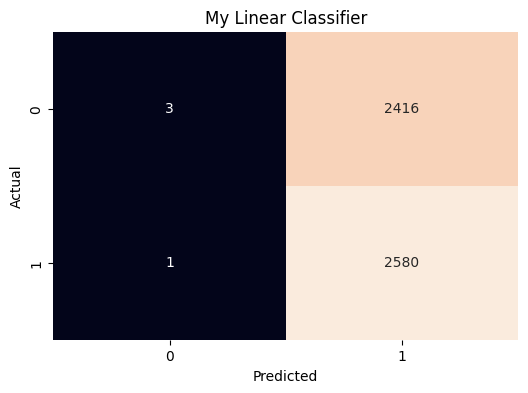

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: My Logistic Regression
Accuracy: 0.4838
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


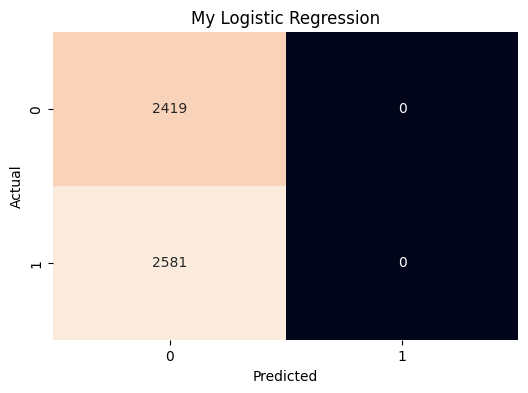

Model: Logistic Regression from sklearn
Accuracy: 0.1680
Precision: 0.2040
Recall: 0.2108
F1 Score: 0.2073


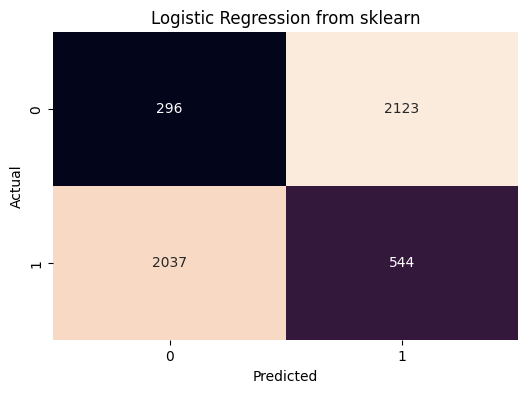

Model: SVM from sklearn
Accuracy: 0.4824
Precision: 0.3793
Recall: 0.0043
F1 Score: 0.0084


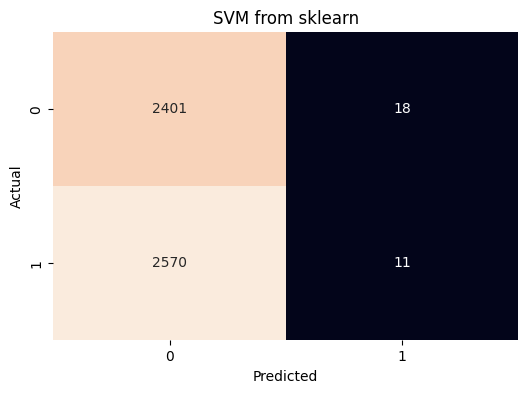

Model: Decision Tree from sklearn
Accuracy: 0.0698
Precision: 0.0132
Recall: 0.0108
F1 Score: 0.0119


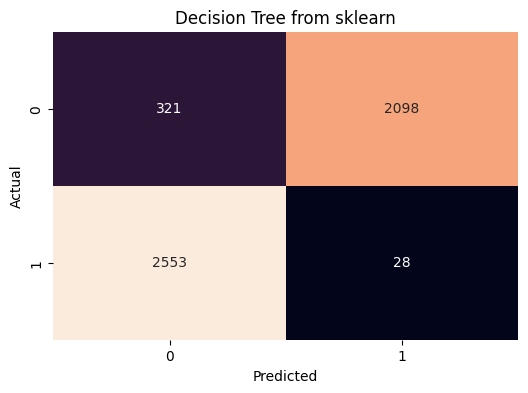

Model: Random Forest
Accuracy: 0.0124
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


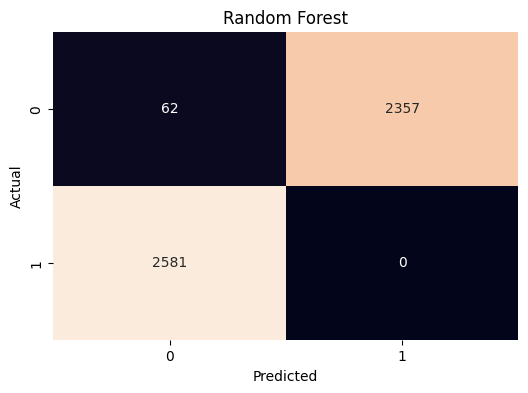

Model: Gradient Boosting from sklearn
Accuracy: 0.0162
Precision: 0.0013
Recall: 0.0012
F1 Score: 0.0012


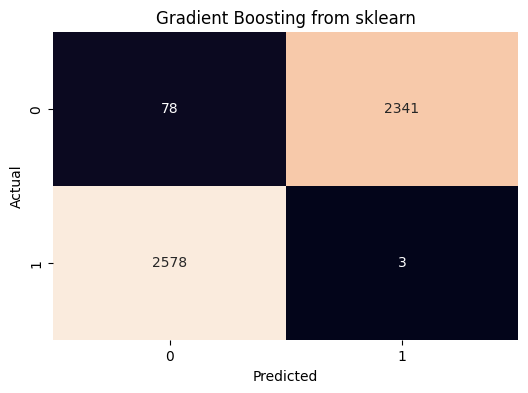

Model: LightGBM
Accuracy: 0.0256
Precision: 0.0004
Recall: 0.0004
F1 Score: 0.0004


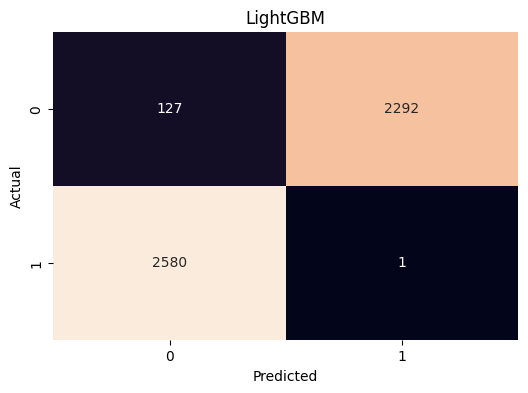

Model: XGBoost
Accuracy: 0.0310
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


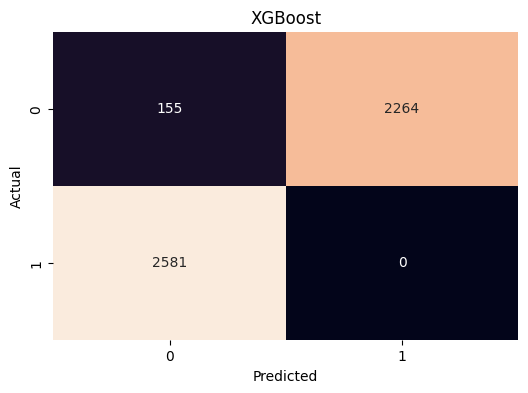

Model: CatBoost
Accuracy: 0.0220
Precision: 0.0004
Recall: 0.0004
F1 Score: 0.0004


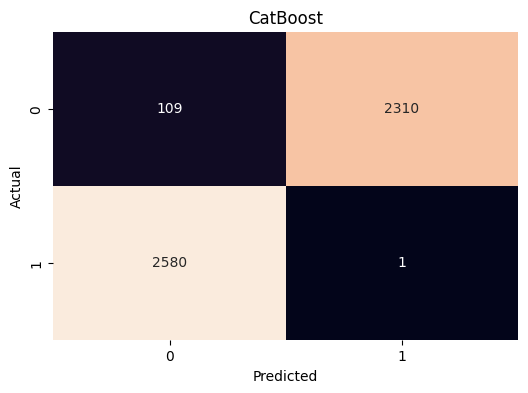

Model: Naive Bayes
Accuracy: 0.4782
Precision: 0.4554
Recall: 0.0554
F1 Score: 0.0988


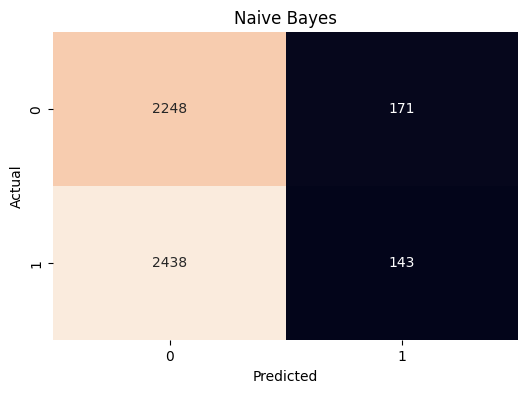


Summary of Model Results:
                               Model  Accuracy  Precision    Recall  F1 Score
0               My Linear Classifier    0.5166   0.516413  0.999613  0.681008
1             My Logistic Regression    0.4838   0.000000  0.000000  0.000000
3                   SVM from sklearn    0.4824   0.379310  0.004262  0.008429
10                       Naive Bayes    0.4782   0.455414  0.055405  0.098791
2   Logistic Regression from sklearn    0.1680   0.203975  0.210771  0.207317
4         Decision Tree from sklearn    0.0698   0.013170  0.010849  0.011897
8                            XGBoost    0.0310   0.000000  0.000000  0.000000
7                           LightGBM    0.0256   0.000436  0.000387  0.000410
9                           CatBoost    0.0220   0.000433  0.000387  0.000409
6     Gradient Boosting from sklearn    0.0162   0.001280  0.001162  0.001218
5                      Random Forest    0.0124   0.000000  0.000000  0.000000


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', cbar=False)
    plt.title(f'{model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

results_summary = []
for name, y_pred in results.items():
    result = evaluate_model(y_test, y_pred, name)
    results_summary.append(result)

results_df = pd.DataFrame(results_summary).sort_values(by='Accuracy', ascending=False)
print("\nSummary of Model Results:")
print(results_df)

В ходе выполнения лабораторной работы на основе предыдущего датасета я протестировала готовые модели и сравнила их результаты с предсказаниями собственных моделей. Результаты показали, что готовые решения демонстрируют более высокую точность, что вполне ожидаемо, так как они включают в себя такие оптимизации, как регуляризация, L-BFGS или SGD. Однако дерево решений продемонстрировало относительно низкий уровень точности, что, вероятно, связано с его склонностью к переобучению.